In [53]:
import tensorflow as tf
import gpflow
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
plt.style.use('ggplot')
%run 'spectral_kernel.ipynb'

# Tests Spectral Kernel

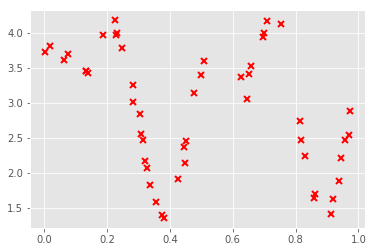

In [3]:
N = 50
X = np.random.rand(N, 1)
f = lambda u: (np.sin(u))
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
plt.plot(X, Y, 'kx', mew=2, c='r')

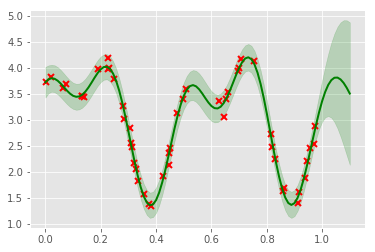

31.467916677996982


In [4]:
import timeit
start = timeit.default_timer()

k = SpectralMixture(q=9)

m = gpflow.models.GPR(X, Y, kern=k)

gpflow.train.GradientDescentOptimizer(learning_rate=1e-2).minimize(m, maxiter=5000)

xx = np.linspace(0, 1.1, 100).reshape(100, 1)
mean, var = m.predict_y(xx)
plt.plot(X, Y, 'kx', mew=2, c='r')
line, = plt.plot(xx, mean, lw=2, c='g')
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), 
                     mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2)
plt.show()

stop = timeit.default_timer()
print(stop - start)

In [63]:
import timeit
start = timeit.default_timer()

k = SpectralMixture(q=8, float32=True)

m = gpflow.models.GPR(np.array(X, dtype=np.float32), 
                      np.array(Y, dtype=np.float32), kern=k)

gpflow.train.GradientDescentOptimizer(learning_rate=1e-2).minimize(m, maxiter=5000)
xx = np.linspace(0, 1.1, 100).reshape(100, 1).astype(np.float32)
mean, var = m.predict_y(xx)
plt.plot(X, Y, 'kx', mew=2, c='r')
line, = plt.plot(xx, mean, lw=2, c='g')
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), 
                     mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2)
plt.show()

stop = timeit.default_timer()
print(stop - start)

ValueError: Tensor conversion requested dtype float32 for Tensor with dtype float64: 'Tensor("1006/GPR/likelihood_1/mul_32:0", shape=(?, ?), dtype=float64)'

## sin

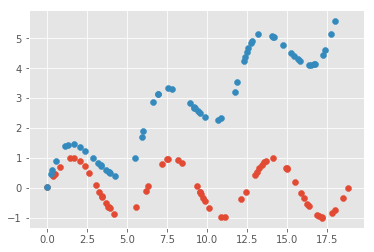

In [5]:
N = 60
X = np.random.uniform(0, 20, size=(N, 1))
f = lambda u: (np.sin(u))
Y = f(X) #+ np.random.randn(N,1)*0.1 + 3
alpha = 0.3
plt.scatter(X,Y)
X_ = X*np.cos(alpha)-Y*np.sin(alpha)
Y_ = X*np.sin(alpha)+Y*np.cos(alpha)
plt.scatter(X_, Y_)

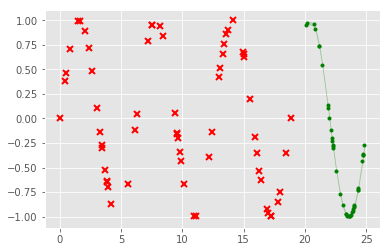

In [15]:
k = SpectralMixture(q=4)

m = gpflow.models.GPR(X, Y, kern=k)
gpflow.train.AdamOptimizer(learning_rate=1e-2).minimize(m, maxiter=1000)

xx = np.random.uniform(20, 25, size=(40, 1))
mean, var = m.predict_y(xx)
plt.plot(X, Y, 'kx', mew=2, c='r')
I = np.argsort(xx[:,0])
line, = plt.plot(xx, mean, '.g', lw=2)
_ = plt.fill_between(xx[I,0], mean[I,0] - 2*np.sqrt(var[I,0]), mean[I,0] + 2*np.sqrt(var[I,0]), color=line.get_color(), alpha=0.2)

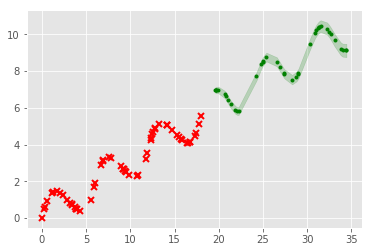

In [13]:
k = SpectralMixture(q=5)
    
#m = gpflow.gpr.GPR(X_, Y_, kern=k)
#m.optimize(method=tf.train.AdamOptimizer(0.01), maxiter=6000)

m = gpflow.models.GPR(X_, Y_, kern=k)
gpflow.train.AdamOptimizer(learning_rate=1e-2).minimize(m, maxiter=6000)

xx = np.random.uniform(18, 35, size=(40, 1))
mean, var = m.predict_y(xx)
plt.plot(X_, Y_, 'kx', mew=2, c='r')
I = np.argsort(xx[:,0])
line, = plt.plot(xx, mean, '.g', lw=2)
_ = plt.fill_between(xx[I,0], mean[I,0] - 2*np.sqrt(var[I,0]), mean[I,0] + 2*np.sqrt(var[I,0]), color=line.get_color(), alpha=0.2)

## CO_2

In [16]:
def get_co2_data(train_len=300, in_order=True):
    data = pd.read_csv('CO2 concentration.txt', sep=" ", header=None)
    data = data.drop([0, 13, 14], axis=1) # years, annual, annual fit
    points = data.values.reshape((-1,))
    points = points[points > 0]
    points = (points - np.mean(points))/np.std(points) # standarize data

    X = np.arange(len(points), dtype=float).reshape((len(points), 1))
    indices = np.random.permutation(X.shape[0]) if not in_order else np.arange(0, X.shape[0])
    indices = indices.reshape((-1,1))
    X_train = indices[0:train_len].astype(float)
    Y_train = points[indices[0:train_len]].reshape((train_len, 1))
    X_pred = indices[train_len:].astype(float)
    Y_true = points[indices[train_len:]].reshape((-1,))
    return X_train, Y_train, X_pred, Y_true

def my_plot(mean, var):
    plt.figure(figsize=(13, 6))
    plt.plot(X_train, Y_train, '.r', label='train')
    plt.plot(X_pred, Y_true, '.b', label='true')
    I = np.argsort(X_pred[:,0])
    line, = plt.plot(X_pred[I,0], mean[I,0], lw=2, c='g', label='pred')
    plt.fill_between(X_pred[I,0], mean[I,0] - 2*np.sqrt(var[I,0]), 
                     mean[I,0] + 2*np.sqrt(var[I,0]), color=line.get_color(), 
                     alpha=0.2, label='variance')
    plt.legend()

### Different ranges

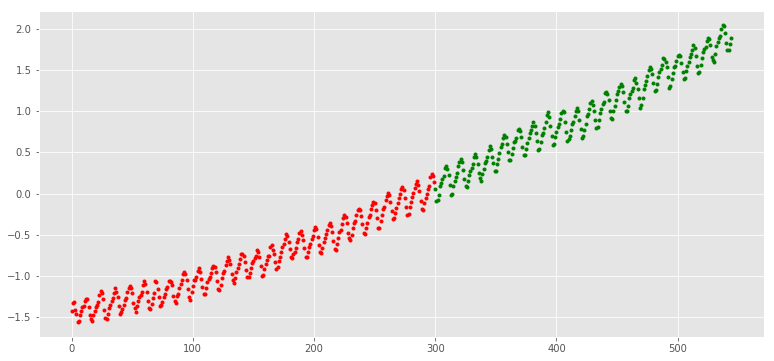

In [17]:
X_train, Y_train, X_pred, Y_true = get_co2_data()
plt.figure(figsize=(13,6))
plt.plot(X_train, Y_train, '.r')
plt.plot(X_pred, Y_true, '.g')

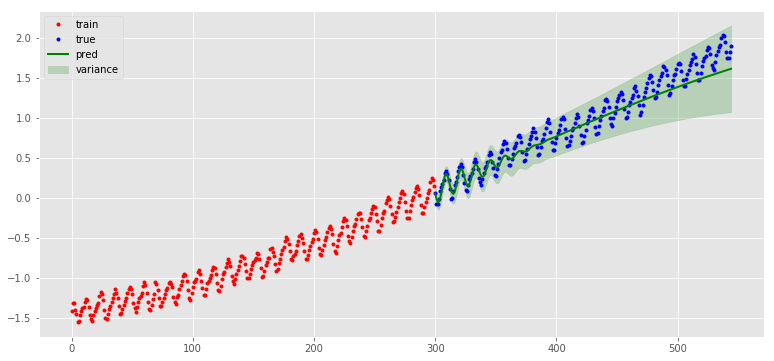

In [18]:
k = SpectralMixture(q=8)

m = gpflow.models.GPR(X_train, Y_train, kern=k)
gpflow.train.AdamOptimizer(learning_rate=1e-3).minimize(m, maxiter=15000)

mean, var = m.predict_y(X_pred)
my_plot(mean, var)

# Tests MOSM

In [19]:
N = 50
X = np.random.rand(N, 1)
f = lambda u: (np.sin(u))
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N, 1)*0.1 + 3

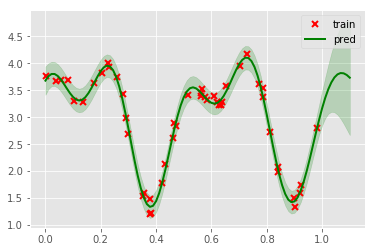

In [26]:
q = 7
I = np.zeros((X.shape[0], 1), dtype=np.int64)
k = MOSpectralMixture(m=1)
for i in range(1, q):
    k += MOSpectralMixture(m=1)

#m = gpflow.gpr.GPR(np.concatenate((X, I), axis=1), Y, kern=k)
#_ = m.optimize(method=tf.train.AdamOptimizer(0.01), maxiter=6000)
m = gpflow.models.GPR(np.concatenate((X, I), axis=1), Y, kern=k)
gpflow.train.AdamOptimizer(learning_rate=0.01).minimize(m, maxiter=8000)

xx = np.linspace(0, 1.1, 100).reshape(100, 1)
i_xx = np.zeros((xx.shape[0], 1), dtype=np.int64)
mean, var = m.predict_y(np.concatenate((xx, i_xx), axis=1))
plt.plot(X, Y, 'kx', mew=2, c='r', label='train')
line, = plt.plot(xx, mean, lw=2, c='g', label='pred')
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), 
                     mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2)
plt.legend()

## Two channels

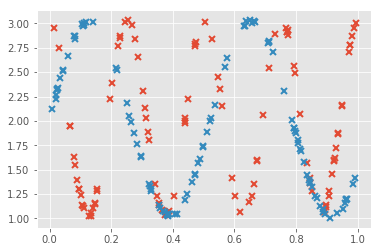

In [122]:
N1 = 100
N2 = 100
X1 = np.random.rand(N1, 1)
X2 = np.random.rand(N2, 1)
Y1 = np.cos(25*X1) + np.random.rand(N1, 1)*0.05 + 2 
Y2 = np.sin(12*X2) + np.random.rand(N2, 1)*0.05 + 2

plt.plot(X1, Y1, 'x', mew=2)
plt.plot(X2, Y2, 'x', mew=2)

In [123]:
X = np.concatenate((X1, X2), axis=0)
Y = np.concatenate((Y1, Y2), axis=0)
I = np.concatenate((np.zeros((N1, 1), dtype=np.int64),
                    np.ones((N2, 1), dtype=np.int64)), axis=0)
k = MOSpectralMixture(m=2)
q = 7
for i in range(1, q):
    k += MOSpectralMixture(m=2)

#m = gpflow.gpr.GPR(np.concatenate((X, I), axis=1), Y, kern=k)
#_ = m.optimize(method=tf.train.AdamOptimizer(0.01), maxiter=15000)

m = gpflow.models.GPR(np.concatenate((X, I), axis=1), Y, kern=k)
gpflow.train.AdamOptimizer(learning_rate=1e-1).minimize(m, maxiter=15000)

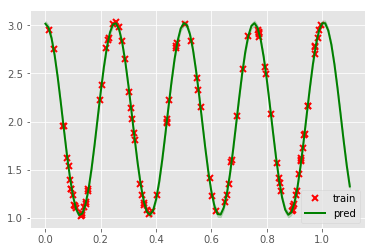

In [124]:
xx = np.linspace(0, 1.1, 100).reshape(100, 1)
i_xx = np.zeros((xx.shape[0], 1), dtype=np.int64)
mean, var = m.predict_y(np.concatenate((xx, i_xx), axis=1))
plt.plot(X[0:N1], Y[0:N1], 'kx', mew=2, c='r', label='train')
line, = plt.plot(xx, mean, lw=2, c='g', label='pred')
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), 
                     mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2)
plt.legend()

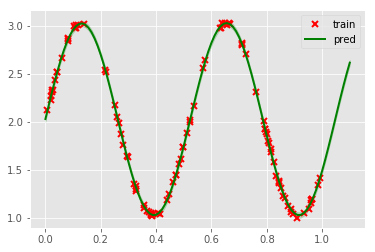

In [125]:
xx = np.linspace(0, 1.1, 100).reshape(100, 1)
i_xx = np.ones((xx.shape[0], 1), dtype=np.int64)
mean, var = m.predict_y(np.concatenate((xx, i_xx), axis=1))
plt.plot(X[N1:], Y[N1:], 'kx', mew=2, c='r', label='train')
line, = plt.plot(xx, mean, lw=2, c='g', label='pred')
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), 
                     mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2)
plt.legend()

## Other two channels

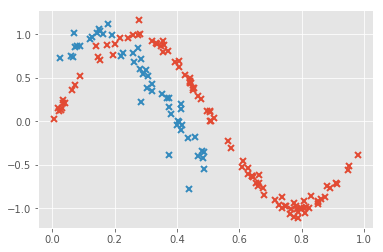

In [118]:
N1 = 100
N2 = 50
X1 = np.random.rand(N1, 1)
X2 = np.random.rand(N2, 1) * 0.5
Y1 = np.sin(6*X1) + np.random.standard_t(3, X1.shape)*0.03
Y2 = np.sin(6*X2+ 0.7) + np.random.standard_t(3, X2.shape)*0.1

plt.plot(X1, Y1, 'x', mew=2)
plt.plot(X2, Y2, 'x', mew=2)

In [119]:
X = np.concatenate((X1, X2), axis=0)
Y = np.concatenate((Y1, Y2), axis=0)
I = np.concatenate((np.zeros((N1, 1), dtype=np.int64),
                    np.ones((N2, 1), dtype=np.int64)), axis=0)
k = MOSpectralMixture(m=2)
q = 7
for i in range(1, q):
    k += MOSpectralMixture(m=2)

#m = gpflow.gpr.GPR(np.concatenate((X, I), axis=1), Y, kern=k)
#_ = m.optimize(method=tf.train.AdamOptimizer(0.01), maxiter=15000)

m = gpflow.models.GPR(np.concatenate((X, I), axis=1), Y, kern=k)
gpflow.train.AdamOptimizer(learning_rate=1e-1).minimize(m, maxiter=15000)

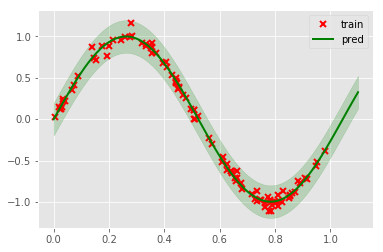

In [120]:
xx = np.linspace(0, 1.1, 100).reshape(100, 1)
i_xx = np.zeros((xx.shape[0], 1), dtype=np.int64)
mean, var = m.predict_y(np.concatenate((xx, i_xx), axis=1))
plt.plot(X[0:N1], Y[0:N1], 'kx', mew=2, c='r', label='train')
line, = plt.plot(xx, mean, lw=2, c='g', label='pred')
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), 
                     mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2)
plt.legend()

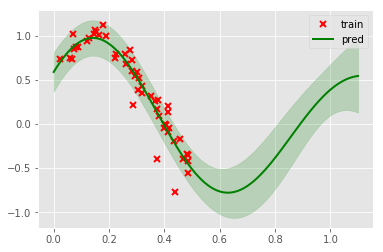

In [121]:
xx = np.linspace(0, 1.1, 100).reshape(100, 1)
i_xx = np.ones((xx.shape[0], 1), dtype=np.int64)
mean, var = m.predict_y(np.concatenate((xx, i_xx), axis=1))
plt.plot(X[N1:], Y[N1:], 'kx', mew=2, c='r', label='train')
line, = plt.plot(xx, mean, lw=2, c='g', label='pred')
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), 
                     mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2)
plt.legend()